In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(cowplot)
  library(gridExtra)
  library(data.table)
  library(ggplot2)
})

cres_w_grnas = fread("cres_with_grnas.txt")
cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt")

# Create the dataframe
df <- data.frame(
  data = c("encode", "gasperini", "stingseq"),
  non_significant = c(111, 8282, 5250),
  significant = c(8, 50, 119)
)

# Convert data to long format for stacked bars
df_long <- pivot_longer(df, cols = c(non_significant, significant), names_to = "type", values_to = "count")


png("plots/num_crispr_assoc.png", width = 8, height = 8,units = "in", res = 300)

# Plot the stacked horizontal barplot with labels
ggplot(df_long, aes(x = data, y = count, fill = type)) +
  geom_bar(stat = "identity") +  # Stacked bars
  geom_text(aes(label = ifelse(data == "encode", "", count)), 
            position = position_stack(vjust = 0.5), size = 5) +  # Remove labels for "encode"
  labs(title = "", x = "", y = "N CRE-gene pairs") +
  theme_minimal() +
  theme(text = element_text(size = 14)) +
  coord_flip() +  # Flip axes for horizontal bars
  scale_fill_manual(values = c("steelblue", "red"))  # Custom colors for clarity

dev.off()

png 
  2

Warning message in fread("CRISPR_data/NoGasperini_crispri_data.tsv"):
“Detected 31 column names but the data has 35 columns (i.e. invalid file). Added 4 extra default column names at the end.”


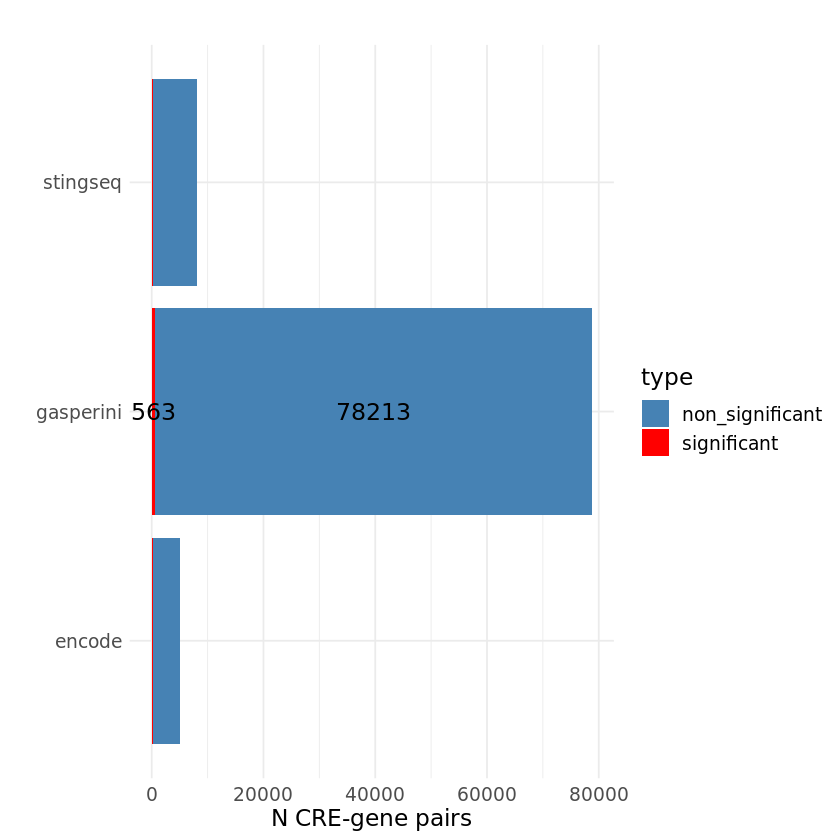

In [3]:
sting_seq = fread("CRISPR_data/All_STING_seq_CREs.csv") %>% rename(SS_coord = `SNP Coordinates (hg19)`)

# Load gasperini data, filter to targeted enhancers
resample_results = fread("CRISPR_data/resampling_results.txt") %>% unique() %>% 
  filter(site_type == "DHS" & quality_rank_grna == "top_two", is.na(target_site.start) == F)

# Load encode reanalysed crispri data, without gasperini data
encode = fread("CRISPR_data/NoGasperini_crispri_data.tsv") %>%
  mutate(target_site = paste0(chrom_GRC37,":",chromStart_GRC37,"-",chromEnd_GRC37)) %>%
  rename(gene_name = measuredGeneSymbol)

# Create the dataframe
df <- data.frame(
  data = c("encode", "gasperini", "stingseq"),
  non_significant = c(sum(encode$Significant == F), 
                      sum(resample_results$rejected == F), 
                      sum(sting_seq$`Q-value (1 Mb)`>0.1)),
  significant = c(sum(encode$Significant == T), 
                  sum(resample_results$rejected == T), 
                  sum(sting_seq$`Q-value (1 Mb)`<0.1))
)

# Convert data to long format for stacked bars
df_long <- pivot_longer(df, cols = c(non_significant, significant), names_to = "type", values_to = "count")

#png("plots/total_crispr_assoc.png", width = 8, height = 8,units = "in", res = 300)

# Plot the stacked horizontal barplot with labels
ggplot(df_long, aes(x = data, y = count, fill = type)) +
  geom_bar(stat = "identity") +  # Stacked bars
  geom_text(aes(label = ifelse(data == "encode" | data == "stingseq", "", count)), 
            position = position_stack(vjust = 0.5), size = 5) +  # Remove labels for "encode"
  labs(title = "", x = "", y = "N CRE-gene pairs") +
  theme_minimal() +
  theme(text = element_text(size = 14)) +
  coord_flip() +  # Flip axes for horizontal bars
  scale_fill_manual(values = c("steelblue", "red"))  # Custom colors for clarity

#dev.off()

Warning message in fread("CRISPR_data/NoGasperini_crispri_data.tsv"):
“Detected 31 column names but the data has 35 columns (i.e. invalid file). Added 4 extra default column names at the end.”


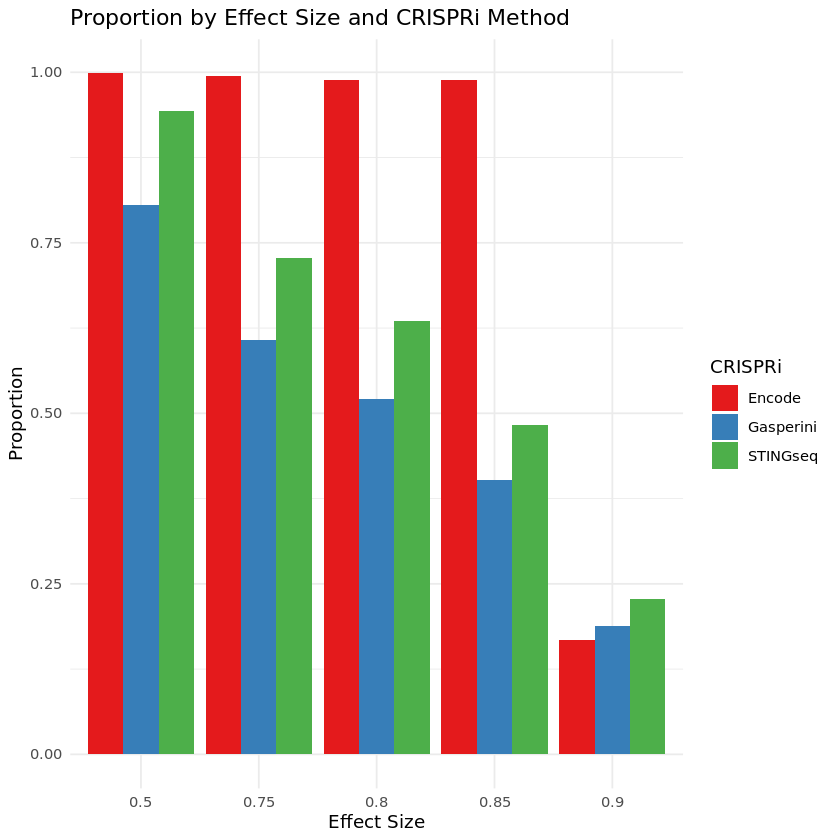

In [4]:
stingseq.p1 = fread("power_results/crispri_power/morris_large_power_per_pair.csv")
stingseq.p2 = fread("power_results/crispri_power/morris_small_power_per_pair.csv")
stingseq.p = rbind(stingseq.p1,stingseq.p2)

# Load gasperini power calculation
gasperini.p = fread("power_results/crispri_power/gasperini_power_per_pair.csv")

encode = fread("CRISPR_data/NoGasperini_crispri_data.tsv") %>%
  mutate(target_site = paste0(chrom_GRC37,":",chromStart_GRC37,"-",chromEnd_GRC37)) %>%
  rename(gene_name = measuredGeneSymbol) %>%
  filter(is.na(PowerAtEffectSize50) == F)

prop_bind = data.frame(effect_size = c(0.5, 0.75, 0.8, 0.85, 0.9))
prop_bind = c()
prop_bind2 = c()
prop_bind3 = c()

for(i in c(0.5,0.75, 0.8, 0.85, 0.9)){
  
  prop = nrow(stingseq.p[effect_size == i & fraction_sig >= 0.8,])/nrow(stingseq.p[effect_size == i,])
  prop2 = nrow(gasperini.p[effect_size == i & fraction_sig >= 0.8,])/nrow(gasperini.p[effect_size == i,])
  prop_bind = c(prop_bind,prop)
  prop_bind2 = c(prop_bind2,prop2)
  
}

for (i in c("PowerAtEffectSize50", "PowerAtEffectSize25", "PowerAtEffectSize20","PowerAtEffectSize15", "PowerAtEffectSize10")) {
  
  prop = sum(encode[[i]] >= 0.8, na.rm=T) / nrow(encode[is.na(encode[[i]]) == F])  # Extract column as a vector using encode[[i]]
  prop_bind3 = c(prop_bind3, prop)  # Append to prop_bind2
  
}

plot_df = data.frame(CRISPRi = rep(c("Encode","Gasperini","STINGseq"), each = 5),
                     effect_size = rep(c(0.5, 0.75, 0.8,0.85, 0.9),3),
                     Proportion = c(prop_bind3, prop_bind2, prop_bind))

#png("plots/power_barplots.png", width = 10, height = 6,units = "in", res = 300)

ggplot(plot_df, aes(x = factor(effect_size), y = Proportion, fill = CRISPRi)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Proportion by Effect Size and CRISPRi Method",
       x = "Effect Size",
       y = "Proportion") +
  theme_minimal() +
  scale_fill_brewer(palette = "Set1")  # Adjust color scheme

#dev.off()

In [17]:
cres_w_grnas = fread("cres_with_grnas.txt") %>%
  mutate(target_gene = paste0(grna_target,"_",ensembl_id))
cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt") %>%
  mutate(target_gene = paste0(grna_target,"_",ensembl_id))

total_cres = unique(cres_w_grnas$grna_target)
grna_cres_w_cgenes = unique(cres_w_grnas$grna_target[cres_w_grnas$significant == 1])
target_cgenes = unique(cres_w_grnas$target_gene[cres_w_grnas$significant == 1])
cgenes = unique(cres_w_grnas$ensembl_id[cres_w_grnas$significant == 1])
grna_cres_w_egenes = unique(cres_w_grnas_egene$grna_target)
target_egenes = unique(cres_w_grnas_egene$target_gene)
egenes = unique(cres_w_grnas_egene$ensembl_id)
cres_no_target = unique(cres_w_grnas$grna_target[!cres_w_grnas$grna_target %in% c(grna_cres_w_cgenes,grna_cres_w_egenes)])
overlapping_cres = grna_cres_w_cgenes[grna_cres_w_cgenes %in% grna_cres_w_egenes]
overlapping_cres_cgene = unique(cres_w_grnas$target_gene[cres_w_grnas$grna_target %in% overlapping_cres & cres_w_grnas$significant == 1])
overlapping_cres_egene = unique(cres_w_grnas_egene$target_gene[cres_w_grnas_egene$grna_target %in% overlapping_cres])
overlapping_target_genes = overlapping_cres_cgene[overlapping_cres_cgene %in% overlapping_cres_egene]

# Load power
crispr.power = fread("cres_with_grnas_power.txt") %>%
  mutate(target_gene = paste0(grna_target,"_",ensembl_id)) %>%
  filter(effect_size == 0.85)

eqtl.power = fread("power_results/eqtl.power.combined.txt") %>%
  mutate(target_gene = paste0(grna_target,"_",ensembl_id)) 

# Filter to overlapping significant CREs
crispr.power.overlap = crispr.power %>%
  distinct(target_gene, .keep_all=T) %>%
  filter(target_gene %in% c(overlapping_cres_egene,overlapping_cres_cgene)) %>%
  mutate(intersect = as.factor(ifelse(target_gene %in% overlapping_target_genes, "Intersection", "No intersection")))

#Fisher exact test
a = sum(crispr.power.overlap$power > 0.79 & crispr.power.overlap$intersect == "Intersection")
b = sum(crispr.power.overlap$power > 0.79 & crispr.power.overlap$intersect == "No intersection")
c = sum(crispr.power.overlap$power < 0.8 & crispr.power.overlap$intersect == "Intersection")
d = sum(crispr.power.overlap$power < 0.8 & crispr.power.overlap$intersect == "No intersection")
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))

# Proportion of genes with p > 0.8
data <- data.frame(
  Gene_type = factor(c("Intersection", "No \n intersection"), levels = c("Intersection", "No \n intersection")),
  Proportion = c(nrow(crispr.power.overlap[power > 0.79 & intersect == "Intersection",])/nrow(crispr.power.overlap[intersect == "Intersection",]),
                 nrow(crispr.power.overlap[power > 0.79 & intersect == "No intersection",])/nrow(crispr.power.overlap[intersect == "No intersection",])))

svg("plots/figure_plots/crispri_power_barplot.svg", width = 4, height = 6)

ggplot(data, aes(x = Gene_type, y = Proportion, fill = "#8766D")) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  labs(title = "", x = "", y = "Proportion of CRE-genes \n with CRISPRi power ≥ 0.80", color = "Gene Type") +
  annotate("text", x = 1.5, y = 0.9, label = paste0("P = ", formatC(test$p.value, format = "e", digits = 1)), size = 5, hjust = 0.5, family = "sans") +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16),
    legend.position = "none"
  )

dev.off()

eqtl.power.overlap = eqtl.power %>%
  distinct(target_gene, .keep_all=T) %>%
  filter(target_gene %in% c(overlapping_cres_egene,overlapping_cres_cgene)) %>%
  mutate(intersect = as.factor(ifelse(target_gene %in% overlapping_target_genes, "Intersection", "No intersection")))

#Fisher exact test
a = sum(eqtl.power.overlap$eQTL.power > 0.79 & eqtl.power.overlap$intersect == "Intersection")
b = sum(eqtl.power.overlap$eQTL.power > 0.79 & eqtl.power.overlap$intersect == "No intersection")
c = sum(eqtl.power.overlap$eQTL.power < 0.8 & eqtl.power.overlap$intersect == "Intersection")
d = sum(eqtl.power.overlap$eQTL.power < 0.8 & eqtl.power.overlap$intersect == "No intersection")
print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))

# Proportion of genes with p > 0.8
data <- data.frame(
  Gene_type = factor(c("Intersection", "No \n intersection"), levels = c("Intersection", "No \n intersection")),
  Proportion = c(nrow(eqtl.power.overlap[eQTL.power > 0.79 & intersect == "Intersection",])/nrow(eqtl.power.overlap[intersect == "Intersection",]),
                 nrow(eqtl.power.overlap[eQTL.power > 0.79 & intersect == "No intersection",])/nrow(eqtl.power.overlap[intersect == "No intersection",])))

svg("plots/figure_plots/eqtl_power_barplot.svg", width = 4, height = 6)

ggplot(data, aes(x = Gene_type, y = Proportion)) +
  geom_bar(stat = "identity", color = "black", fill = "#00BFC4", width = 0.5, position = position_dodge(width = 0.7)) +
  labs(title = "", x = "", y = "Proportion of CRE-genes \n with eQTL power ≥ 0.80") +
  annotate("text", x = 1.5, y = 1.02, label = paste0("P = ", formatC(test$p.value, format = "e", digits = 1)), size = 5, hjust = 0.5, family = "sans") +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 16),
    legend.position = "none"
  )

dev.off()

     [,1] [,2]
[1,]   56   12
[2,]   97   67


png 
  2

     [,1] [,2]
[1,]   65    3
[2,]  218    9


png 
  2

In [15]:
# MAF vs power
# Load sumstats to obtain MAFs
sumstats = fread("/gpfs/commons/groups/lappalainen_lab/sghatan/stingseq_eqtl_overlap/data/UKBB_sumstats/30000_formatted.tsv")
sumstats$snp_pos = paste0(sumstats$Chr,":",sumstats$Pos)
sumstats_filtered = sumstats %>% filter(snp_pos %in% eqtl.power$grna_target)

# Define MAF bins (0-50 in sets of 10)
sumstats_filtered <- sumstats_filtered %>%
  mutate(MAF_bin = cut(minor_AF, breaks = seq(0, 0.50, by = 0.1), include.lowest = TRUE))

In [19]:
# Merge the data
plot_df <- eqtl.power %>%
  left_join(sumstats_filtered[, c("snp_pos", "minor_AF", "MAF_bin")], 
            by = c("grna_target" = "snp_pos")) %>%
    filter(is.na(minor_AF) ==F)

# Compute proportion of genes with power > 0.79 per MAF bin
barplot_data <- plot_df %>%
  group_by(MAF_bin) %>%
  summarise(
    total_genes = n(),
    high_power_genes = sum(eQTL.power > 0.79, na.rm = TRUE),
    proportion = high_power_genes / total_genes
  )

png("plots/eqtl_maf_power_barplot.png", width = 8, height = 6, units = "in", res = 300)
# Create bar plot of proportions
ggplot(barplot_data, aes(x = MAF_bin, y = proportion)) +
  geom_bar(stat = "identity", alpha = 0.7) +
  theme_minimal() +
  labs(title = "Proportion of Genes with eQTL Power ≥ 0.8 by MAF",
       x = "Minor Allele Frequency (MAF) Bin",
       y = "Proportion of Genes") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
dev.off()

png 
  2